# Setup

In [1]:
import json
import os
import sys
import pickle
import warnings

sys.path.append('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from flaml import AutoML

from sklearn.metrics import balanced_accuracy_score, median_absolute_error

from utils import read_csv_non_utf, preprocess_data, ratios_to_DI_cats, get_train_test_split, \
                  get_zero_nonzero_datasets, test_thresholds, direct_train_test
from model_utils import HurdleModelEstimator
from custom_metrics import balanced_accuracy_FLAML
from performance_reports import get_regression_report, get_classification_report

## Loading the data

In [2]:
# Loading in general configuration
with open('../config.json', 'r') as f:
    config = json.load(f)

# Getting filepaths
gdrive_fp = config['gdrive_path']
LIFE_fp = config['LIFE_folder']
dataset_fp = config['datasets_path']
benitez_lopez2019 = config['indiv_data_paths']['benitez_lopez2019']

data_path = os.path.join(gdrive_fp, LIFE_fp, dataset_fp, benitez_lopez2019)

In [3]:
# Reading in data as a pandas dataframe
ben_lop2019 = read_csv_non_utf(data_path)

# Direct regression and classificaiton

I am using Microsoft's [`flaml`](https://github.com/microsoft/FLAML) for AutoML, which supports a range of models: 
- [Light Gradient Boosting Machine (LGBM)](https://github.com/microsoft/LightGBM),
- [Extreme Gradient Boosting (XGBoost)](https://github.com/dmlc/xgboost),
- [Random Forest (RF)](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor),
- [Extra Trees](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesRegressor.html),
- [Histogram Gradient Boosting](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingRegressor.html#sklearn.ensemble.HistGradientBoostingRegressor),
- [Categorical Boosting (CatBoost)](https://github.com/catboost/catboost),
- [$k$-Nearest Neighbors ($k$-NN)](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html).

Noticeably, linear models and neural networks are missing from the mix, but we may be able to use `flaml` to perform [efficient hyperparameter tuning](https://microsoft.github.io/FLAML/docs/Use-Cases/Task-Oriented-AutoML#guidelines-on-tuning-a-custom-estimator) on these using `sklearn` or `PyTorch` implementations.

In [4]:
# Getting train/test data
task = 'classification'
X_train, y_train, X_test, y_test = direct_train_test(ben_lop2019, train_size = 0.7, task = task)

print(f'{task.upper()} TARGET')
print(f'Train shape: X{X_train.shape}, y{y_train.shape}')
print(f'Test shape: X{X_test.shape}, y{y_test.shape}')

CLASSIFICATION TARGET
Train shape: X(2296, 8), y(2296,)
Test shape: X(985, 8), y(985,)


In [32]:
# Initialize the auto ML instance
automl = AutoML()
time_budget_mins = 5

# Specify paramaters
base_path = os.path.join('..', 'model_saves', f'direct_{task}')
automl_settings = {
    'time_budget' : time_budget_mins * 60,  # in seconds
    'metric' : 'mae' if task == 'regression' else balanced_accuracy_FLAML,
    'task' : task,
    'log_file_name' : os.path.join(base_path, f'mammals_direct_{task}.log'),
    'seed' : 1693,
    'estimator_list' : ['lgbm', 'xgboost', 'xgb_limitdepth', 'rf', 'extra_tree', 'kneighbor'],
    'early_stop' : True,
    'verbose' : 3
}

# Train with labeled input data
automl.fit(X_train = X_train, y_train = y_train, **automl_settings)

[flaml.automl.logger: 05-23 15:31:59] {1680} INFO - task = classification
[flaml.automl.logger: 05-23 15:31:59] {1691} INFO - Evaluation method: cv
[flaml.automl.logger: 05-23 15:31:59] {1789} INFO - Minimizing error metric: customized metric
[flaml.automl.logger: 05-23 15:31:59] {1901} INFO - List of ML learners in AutoML Run: ['lgbm', 'xgboost', 'xgb_limitdepth', 'rf', 'extra_tree', 'kneighbor']
[flaml.automl.logger: 05-23 15:31:59] {2219} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 05-23 15:31:59] {2345} INFO - Estimated sufficient time budget=910s. Estimated necessary time budget=9s.
[flaml.automl.logger: 05-23 15:31:59] {2392} INFO -  at 0.2s,	estimator lgbm's best error=0.6667,	best estimator lgbm's best error=0.6667
[flaml.automl.logger: 05-23 15:31:59] {2219} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 05-23 15:31:59] {2392} INFO -  at 0.3s,	estimator lgbm's best error=0.5427,	best estimator lgbm's best error=0.5427
[flaml.automl.logger: 05

CLASSIFICATION PERFORMANCE
--------------------------
              precision    recall  f1-score   support

         low       0.82      0.80      0.81       560
      medium       0.41      0.43      0.42       207
        high       0.54      0.54      0.54       218

    accuracy                           0.67       985
   macro avg       0.59      0.59      0.59       985
weighted avg       0.67      0.67      0.67       985

Balanced accuracy: 59.11%


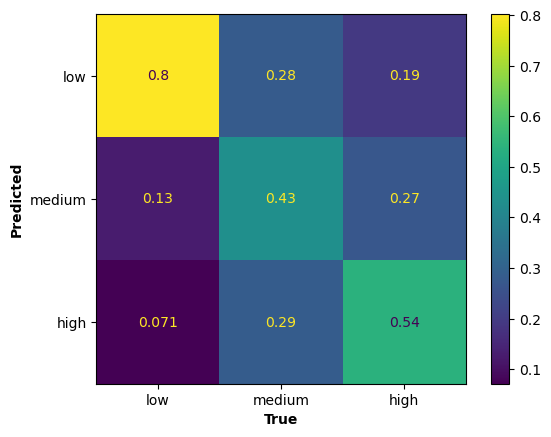

In [33]:
# Getting regression and classification true vs. predicted
if task == 'regression':
    pred_ratios = automl.predict(X_test)
    test_ratios = y_test

    pred_DI_cats = ratios_to_DI_cats(pred_ratios)
    true_DI_cats = ratios_to_DI_cats(test_ratios)
elif task == 'classification':
    pred_DI_cats = automl.predict(X_test)
    true_DI_cats = y_test

print('CLASSIFICATION PERFORMANCE')
print('--------------------------')
get_classification_report(true_DI_cats, pred_DI_cats, printout = True)

if task == 'regression':
    print()
    print('REGRESSION PERFORMANCE')
    print('----------------------')
    get_regression_report(test_ratios, pred_ratios, printout = True)

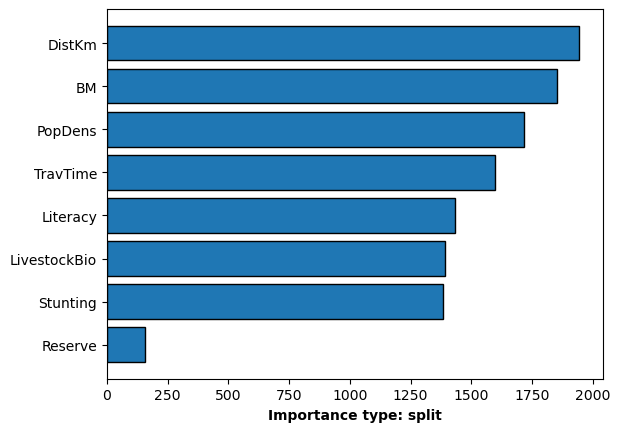

In [35]:
# Taking a look at feature importance - might break if the best model isn't LGBM!
features = np.array(automl.model.estimator.feature_name_)
importances = np.array(automl.model.estimator.feature_importances_)
sort_order = np.argsort(importances)

plt.barh(features[sort_order], importances[sort_order], edgecolor = 'black')
plt.xlabel(f'Importance type: {automl.model.estimator.importance_type}', weight = 'bold');

# Non-linear hurdle model via AutoML

What if we use AutoML to find the best regression and classification models for a two-stage hurdle model?

In [54]:
# Preparing the data for the zero and nonzero models
idxs = get_train_test_split(len(ben_lop2019), train_size = 0.7)

embeddings_to_use = ['SatCLIP', 'BioCLIP']
embeddings_args = {'pca' : False,
                   'var_cutoff' : 0.9}
pp_data = preprocess_data(ben_lop2019, include_indicators = False, standardize = True, log_trans_cont = False,
                          polynomial_features = 0, train_test_idxs = idxs, embeddings_to_use = embeddings_to_use,
                          embeddings_args = embeddings_args)

train_data, test_data = pp_data.loc[idxs['train']], pp_data.loc[idxs['test']]

In [59]:
# General parameters
time_budget_mins = 3
base_path = os.path.join('..', 'model_saves')
verbose = 3
extirp_pos = False

zero_columns = ['BM', 'DistKm', 'PopDens', 'Stunting', 'TravTime', 'LivestockBio', 'Literacy', 'Reserve']
nonzero_columns = zero_columns
indicator_columns = []

zero_metric = balanced_accuracy_FLAML
nonzero_metric = 'mse'

# Setting up the zero and nonzero models
zero_model = AutoML()
nonzero_model = AutoML()

#  specify fitting paramaters
zero_settings = {
    'time_budget' : time_budget_mins * 60,  # in seconds
    'metric' : zero_metric,
    'task' : 'classification',
    'log_file_name' : os.path.join(base_path, f'nonlinear_hurdle.log'),
    'seed' : 1693,
    'estimator_list' : ['lgbm', 'xgboost', 'xgb_limitdepth', 'rf', 
                        'extra_tree', 'kneighbor', 'lrl1', 'lrl2'],
    'early_stop' : True,
    'verbose' : verbose,
    'keep_search_state' : True
}

nonzero_settings = {
    'time_budget' : time_budget_mins * 60,  # in seconds
    'metric' : nonzero_metric,
    'task' : 'regression',
    'log_file_name' : os.path.join(base_path, f'nonlinear_hurdle.log'),
    'seed' : 1693,
    'estimator_list' : ['lgbm', 'xgboost', 'xgb_limitdepth', 'rf', 'extra_tree', 'kneighbor'],
    'early_stop' : True,
    'verbose' : verbose,
    'keep_search_state' : True
}

settings = {'zero' : zero_settings, 'nonzero' : nonzero_settings}

#  dumping everything into the hurdle model wrapper
data_args = {'indicator_columns' : indicator_columns,
             'nonzero_columns' : nonzero_columns,
             'zero_columns' : zero_columns,
             'embeddings_to_use' : embeddings_to_use}
hurdle_model = HurdleModelEstimator(zero_model, nonzero_model, extirp_pos = extirp_pos, 
                                    data_args = data_args, verbose = True)

In [60]:
# Fitting the two constituent models
hurdle_model.fit(train_data, fit_args = settings)

Fitting the nonzero model...
[flaml.automl.logger: 06-08 20:15:02] {1680} INFO - task = regression
[flaml.automl.logger: 06-08 20:15:02] {1691} INFO - Evaluation method: holdout
[flaml.automl.logger: 06-08 20:15:02] {1789} INFO - Minimizing error metric: mse
[flaml.automl.logger: 06-08 20:15:02] {1901} INFO - List of ML learners in AutoML Run: ['lgbm', 'xgboost', 'xgb_limitdepth', 'rf', 'extra_tree', 'kneighbor']
[flaml.automl.logger: 06-08 20:15:02] {2219} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 06-08 20:15:03] {2345} INFO - Estimated sufficient time budget=3386s. Estimated necessary time budget=34s.
[flaml.automl.logger: 06-08 20:15:03] {2392} INFO -  at 1.2s,	estimator lgbm's best error=0.9283,	best estimator lgbm's best error=0.9283
[flaml.automl.logger: 06-08 20:15:03] {2219} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 06-08 20:15:03] {2392} INFO -  at 1.6s,	estimator lgbm's best error=0.8635,	best estimator lgbm's best error=0.8635
[flaml

/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[flaml.automl.logger: 06-08 20:19:45] {2392} INFO -  at 102.3s,	estimator lrl2's best error=0.3958,	best estimator lgbm's best error=0.2743
[flaml.automl.logger: 06-08 20:19:45] {2219} INFO - iteration 140, current learner lgbm
[flaml.automl.logger: 06-08 20:19:45] {2392} INFO -  at 103.0s,	estimator lgbm's best error=0.2743,	best estimator lgbm's best error=0.2743
[flaml.automl.logger: 06-08 20:19:45] {2219} INFO - iteration 141, current learner extra_tree
[flaml.automl.logger: 06-08 20:19:46] {2392} INFO -  at 103.2s,	estimator extra_tree's best error=0.4864,	best estimator lgbm's best error=0.2743
[flaml.automl.logger: 06-08 20:19:46] {2219} INFO - iteration 142, current learner lgbm
[flaml.automl.logger: 06-08 20:19:47] {2392} INFO -  at 104.2s,	estimator lgbm's best error=0.2743,	best estimator lgbm's best error=0.2743
[flaml.automl.logger: 06-08 20:19:47] {2219} INFO - iteration 143, current learner lrl2


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[flaml.automl.logger: 06-08 20:19:48] {2392} INFO -  at 105.7s,	estimator lrl2's best error=0.3847,	best estimator lgbm's best error=0.2743
[flaml.automl.logger: 06-08 20:19:48] {2219} INFO - iteration 144, current learner extra_tree
[flaml.automl.logger: 06-08 20:19:48] {2392} INFO -  at 105.9s,	estimator extra_tree's best error=0.4864,	best estimator lgbm's best error=0.2743
[flaml.automl.logger: 06-08 20:19:48] {2219} INFO - iteration 145, current learner rf
[flaml.automl.logger: 06-08 20:19:49] {2392} INFO -  at 106.3s,	estimator rf's best error=0.3140,	best estimator lgbm's best error=0.2743
[flaml.automl.logger: 06-08 20:19:49] {2219} INFO - iteration 146, current learner lgbm
[flaml.automl.logger: 06-08 20:19:52] {2392} INFO -  at 109.4s,	estimator lgbm's best error=0.2743,	best estimator lgbm's best error=0.2743
[flaml.automl.logger: 06-08 20:19:52] {2219} INFO - iteration 147, current learner kneighbor
[flaml.automl.logger: 06-08 20:19:52] {2392} INFO -  at 109.7s,	estimator k

/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[flaml.automl.logger: 06-08 20:20:09] {2392} INFO -  at 126.8s,	estimator kneighbor's best error=0.3438,	best estimator lgbm's best error=0.2743
[flaml.automl.logger: 06-08 20:20:09] {2219} INFO - iteration 179, current learner xgboost
[flaml.automl.logger: 06-08 20:20:10] {2392} INFO -  at 127.8s,	estimator xgboost's best error=0.3598,	best estimator lgbm's best error=0.2743
[flaml.automl.logger: 06-08 20:20:10] {2219} INFO - iteration 180, current learner kneighbor
[flaml.automl.logger: 06-08 20:20:10] {2392} INFO -  at 127.9s,	estimator kneighbor's best error=0.3438,	best estimator lgbm's best error=0.2743
[flaml.automl.logger: 06-08 20:20:10] {2219} INFO - iteration 181, current learner kneighbor
[flaml.automl.logger: 06-08 20:20:10] {2392} INFO -  at 128.1s,	estimator kneighbor's best error=0.3438,	best estimator lgbm's best error=0.2743
[flaml.automl.logger: 06-08 20:20:10] {2219} INFO - iteration 182, current learner kneighbor
[flaml.automl.logger: 06-08 20:20:11] {2392} INFO - 

/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-08 20:20:23] {2392} INFO -  at 141.1s,	estimator lrl1's best error=0.4591,	best estimator lgbm's best error=0.2743
[flaml.automl.logger: 06-08 20:20:23] {2219} INFO - iteration 196, current learner lrl2


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-08 20:20:25] {2392} INFO -  at 143.0s,	estimator lrl2's best error=0.3686,	best estimator lgbm's best error=0.2743
[flaml.automl.logger: 06-08 20:20:25] {2219} INFO - iteration 197, current learner lgbm


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[flaml.automl.logger: 06-08 20:20:28] {2392} INFO -  at 145.7s,	estimator lgbm's best error=0.2743,	best estimator lgbm's best error=0.2743
[flaml.automl.logger: 06-08 20:20:28] {2219} INFO - iteration 198, current learner lgbm
[flaml.automl.logger: 06-08 20:20:28] {2392} INFO -  at 146.1s,	estimator lgbm's best error=0.2743,	best estimator lgbm's best error=0.2743
[flaml.automl.logger: 06-08 20:20:28] {2219} INFO - iteration 199, current learner rf
[flaml.automl.logger: 06-08 20:20:29] {2392} INFO -  at 146.4s,	estimator rf's best error=0.3140,	best estimator lgbm's best error=0.2743
[flaml.automl.logger: 06-08 20:20:29] {2219} INFO - iteration 200, current learner rf
[flaml.automl.logger: 06-08 20:20:29] {2392} INFO -  at 146.6s,	estimator rf's best error=0.3140,	best estimator lgbm's best error=0.2743
[flaml.automl.logger: 06-08 20:20:29] {2219} INFO - iteration 201, current learner lrl1
[flaml.automl.logger: 06-08 20:20:32] {2392} INFO -  at 149.7s,	estimator lrl1's best error=0.45

/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-08 20:20:35] {2392} INFO -  at 152.7s,	estimator lrl1's best error=0.4429,	best estimator lgbm's best error=0.2743
[flaml.automl.logger: 06-08 20:20:35] {2219} INFO - iteration 203, current learner lgbm


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-08 20:20:35] {2392} INFO -  at 153.1s,	estimator lgbm's best error=0.2743,	best estimator lgbm's best error=0.2743
[flaml.automl.logger: 06-08 20:20:35] {2219} INFO - iteration 204, current learner lgbm
[flaml.automl.logger: 06-08 20:20:36] {2392} INFO -  at 153.9s,	estimator lgbm's best error=0.2743,	best estimator lgbm's best error=0.2743
[flaml.automl.logger: 06-08 20:20:36] {2219} INFO - iteration 205, current learner rf
[flaml.automl.logger: 06-08 20:20:37] {2392} INFO -  at 154.3s,	estimator rf's best error=0.3140,	best estimator lgbm's best error=0.2743
[flaml.automl.logger: 06-08 20:20:37] {2219} INFO - iteration 206, current learner lrl1
[flaml.automl.logger: 06-08 20:20:40] {2392} INFO -  at 157.3s,	estimator lrl1's best error=0.4429,	best estimator lgbm's best error=0.2743
[flaml.automl.logger: 06-08 20:20:40] {2219} INFO - iteration 207, current learner lrl1


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-08 20:20:43] {2392} INFO -  at 160.6s,	estimator lrl1's best error=0.4429,	best estimator lgbm's best error=0.2743
[flaml.automl.logger: 06-08 20:20:43] {2219} INFO - iteration 208, current learner xgboost


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-08 20:20:44] {2392} INFO -  at 161.7s,	estimator xgboost's best error=0.3598,	best estimator lgbm's best error=0.2743
[flaml.automl.logger: 06-08 20:20:44] {2219} INFO - iteration 209, current learner extra_tree
[flaml.automl.logger: 06-08 20:20:44] {2392} INFO -  at 161.9s,	estimator extra_tree's best error=0.4864,	best estimator lgbm's best error=0.2743
[flaml.automl.logger: 06-08 20:20:44] {2219} INFO - iteration 210, current learner rf
[flaml.automl.logger: 06-08 20:20:45] {2392} INFO -  at 162.3s,	estimator rf's best error=0.3140,	best estimator lgbm's best error=0.2743
[flaml.automl.logger: 06-08 20:20:45] {2219} INFO - iteration 211, current learner xgboost
[flaml.automl.logger: 06-08 20:20:45] {2392} INFO -  at 162.8s,	estimator xgboost's best error=0.3598,	best estimator lgbm's best error=0.2743
[flaml.automl.logger: 06-08 20:20:45] {2219} INFO - iteration 212, current learner xgboost
[flaml.automl.logger: 06-08 20:20:47] {2392} INFO -  at 164.2s,	esti

/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-08 20:20:51] {2392} INFO -  at 168.9s,	estimator extra_tree's best error=0.4864,	best estimator lgbm's best error=0.2743
[flaml.automl.logger: 06-08 20:20:51] {2219} INFO - iteration 217, current learner xgboost
[flaml.automl.logger: 06-08 20:20:52] {2392} INFO -  at 169.5s,	estimator xgboost's best error=0.3598,	best estimator lgbm's best error=0.2743
[flaml.automl.logger: 06-08 20:20:52] {2219} INFO - iteration 218, current learner lrl2
[flaml.automl.logger: 06-08 20:20:53] {2392} INFO -  at 170.9s,	estimator lrl2's best error=0.3686,	best estimator lgbm's best error=0.2743
[flaml.automl.logger: 06-08 20:20:53] {2219} INFO - iteration 219, current learner lgbm
[flaml.automl.logger: 06-08 20:20:54] {2392} INFO -  at 171.5s,	estimator lgbm's best error=0.2743,	best estimator lgbm's best error=0.2743
[flaml.automl.logger: 06-08 20:20:54] {2219} INFO - iteration 220, current learner lgbm
[flaml.automl.logger: 06-08 20:20:54] {2392} INFO -  at 171.9s,	estimator lg

/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-08 20:21:00] {2392} INFO -  at 177.5s,	estimator rf's best error=0.3140,	best estimator lgbm's best error=0.2743
[flaml.automl.logger: 06-08 20:21:00] {2219} INFO - iteration 226, current learner lgbm
[flaml.automl.logger: 06-08 20:21:00] {2392} INFO -  at 178.0s,	estimator lgbm's best error=0.2743,	best estimator lgbm's best error=0.2743
[flaml.automl.logger: 06-08 20:21:00] {2219} INFO - iteration 227, current learner lgbm
[flaml.automl.logger: 06-08 20:21:01] {2392} INFO -  at 178.6s,	estimator lgbm's best error=0.2743,	best estimator lgbm's best error=0.2743
[flaml.automl.logger: 06-08 20:21:01] {2219} INFO - iteration 228, current learner lgbm
[flaml.automl.logger: 06-08 20:21:02] {2392} INFO -  at 179.6s,	estimator lgbm's best error=0.2743,	best estimator lgbm's best error=0.2743
[flaml.automl.logger: 06-08 20:21:02] {2219} INFO - iteration 229, current learner rf
[flaml.automl.logger: 06-08 20:21:02] {2392} INFO -  at 179.9s,	estimator rf's best error=0.

In [61]:
# Checking which models were chosen
print('Nonzero model:', hurdle_model.nonzero_model.model.estimator_class)
print('Zero model:', hurdle_model.zero_model.model.estimator_class)

Nonzero model: <class 'lightgbm.sklearn.LGBMRegressor'>
Zero model: <class 'lightgbm.sklearn.LGBMClassifier'>


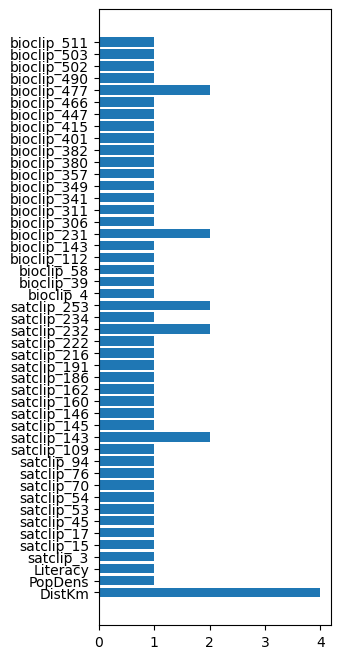

In [77]:
model = hurdle_model.nonzero_model

imp = model.feature_importances_
feat = np.array(model.feature_names_in_)

# imp_mask = imp > np.percentile(imp, 70)
imp_mask = imp != 0
imp = imp[imp_mask]
feat = feat[imp_mask]

plt.figure(figsize = (3, 8))
plt.barh(feat, imp);

In [73]:
# Tuning the threshold for the zero model
X_zero, y_zero, _, _ = get_zero_nonzero_datasets(train_data, extirp_pos = extirp_pos, pred = False, **data_args)
y_pred = hurdle_model.zero_model.predict_proba(X_zero)[ : , 1]

opt_thresh, metrics = test_thresholds(y_pred, y_zero)
hurdle_model.prob_thresh = round(opt_thresh, 3)
print(f'Best threshold was found to be {round(opt_thresh, 3)} with a TSS of {round(np.max(metrics["TSS"]), 3)}')

Best threshold was found to be 0.7 with a TSS of 0.967


In [74]:
# Predicting with the final hurdle model
y_test = test_data['ratio']
y_pred = hurdle_model.predict(test_data)
y_pred[y_pred != 0] = np.exp(y_pred[y_pred != 0])

pred_DI_cats = ratios_to_DI_cats(y_pred)
true_DI_cats = ratios_to_DI_cats(y_test)

CLASSIFICATION PERFORMANCE
--------------------------
              precision    recall  f1-score   support

         low       0.76      0.50      0.61       560
      medium       0.25      0.55      0.35       207
        high       0.56      0.43      0.48       218

    accuracy                           0.50       985
   macro avg       0.53      0.49      0.48       985
weighted avg       0.61      0.50      0.53       985

Balanced accuracy: 49.36%


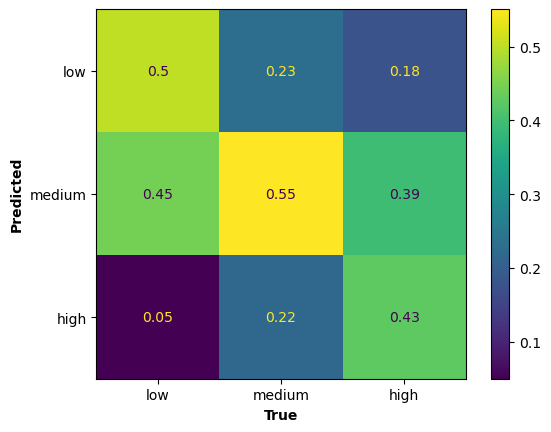


REGRESSION PERFORMANCE
----------------------
Mean absolute error: 0.903
Median absolute error: 0.319
Root mean squared error: 3.368
Root median squared error: 0.319


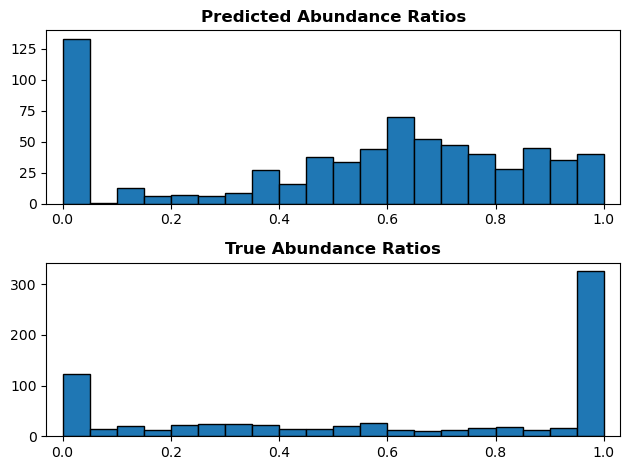

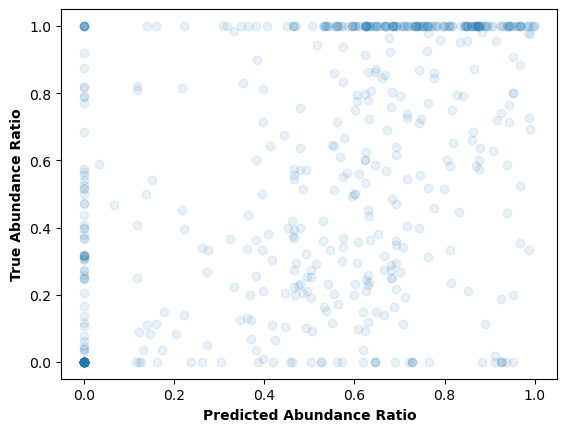

In [75]:
# Assessing classification and regression performance
upper_thresh = 1

print('CLASSIFICATION PERFORMANCE')
print('--------------------------')
get_classification_report(true_DI_cats, pred_DI_cats, printout = True)

print()

print('REGRESSION PERFORMANCE')
print('----------------------')
get_regression_report(y_test, y_pred, printout = True, upper_thresh = upper_thresh)